<a href="https://colab.research.google.com/github/Aman56/grok/blob/main/parity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Parity learning simulations

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import copy

import random

device = 'cuda' if torch.cuda.is_available() else 'cpu'

n = 40 # string dimension
k = 3 # parity dimension
N = 1000 # #samples
B = 32 # batch size
lr = 0.1 # learning rate

# Data generation
def parity(n, k, samples, seed=42):

  random.seed(seed)
  input = torch.Tensor([[random.choice([-1, 1]) for j in range(n)] for i in range(samples)])
  # target = torch.prod(input[:, n//2:n//2+k], dim=1) # parity hidden in the middle
  target = torch.prod(input[:, :k], dim=1) # parity hidden in first k bits

  return input, target


class FF1(torch.nn.Module):
    def __init__(self, width=1000):
      super(FF1, self).__init__()
      self.linear1 = torch.nn.Linear(n, width)
      self.activation = torch.nn.ReLU()
      self.linear2 = torch.nn.Linear(width, 1, bias=False)

    def forward(self, x):
      x = self.linear1(x)
      x = self.activation(x)
      x = self.linear2(x)
      return x

class MyHingeLoss(torch.nn.Module):
  def __init__(self):
    super(MyHingeLoss, self).__init__()

  def forward(self, output, target):
    hinge_loss = 1 - torch.mul(torch.squeeze(output), torch.squeeze(target))
    hinge_loss[hinge_loss < 0] = 0
    return hinge_loss

loss_fn = MyHingeLoss()

In [45]:
from torch.utils.data import TensorDataset, DataLoader
data = parity(n, k, N)
train_dataset = TensorDataset(data[0], data[1])
train_dataloader = DataLoader(train_dataset, batch_size=B, shuffle=True)

data = parity(n, k, 100, seed=101) # test samples
test_dataset = TensorDataset(data[0], data[1])
test_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=True)

In [46]:
import matplotlib.pyplot as plt

T = 500 # epochs
reg_lambda = 0.01

def acc_calc(dataloader, model):
  acc = 0
  for id, (x_batch, y_batch) in enumerate(dataloader):
    pred = model(x_batch)
    acc += (torch.sign(torch.squeeze(pred)) == y_batch.to(device)).sum().item()

  if (id > 0):
    return acc / N # train set
  else:
    return acc / x_batch.shape[0] # test set

def loss_calc(dataloader, model):
  loss = 0
  for id, (x_batch, y_batch) in enumerate(dataloader):
    pred = model(x_batch)
    loss += loss_fn(pred, y_batch.to(device)).sum().item()

  if (id > 0):
    return loss / N # train set
  else:
    return loss / x_batch.shape[0] # test set

num_seeds = 1
for seed_id in range(num_seeds):
  torch.manual_seed(seed_id)
  # print(seed_id)
  model = FF1()
  model = model.to(device)
  
  if device == 'cuda':
    model = torch.nn.DataParallel(model)
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=reg_lambda)


  train_loss, test_loss = [], []
  train_acc, test_acc = [], []
  norms = {'feats':  [],
           'conx':  []}
  for epoch in range(T):
    if (epoch % 100 == 0):
      print(f"Epoch {epoch + 1}\n-------------------------------")

    norms['feats'].append(torch.linalg.norm(list(model.parameters())[0], dim=1).detach().cpu().numpy())
    norms['conx'].append(torch.squeeze(list(model.parameters())[2]).detach().cpu().numpy())
    train_loss.append(loss_calc(train_dataloader, model))
    test_loss.append(loss_calc(test_dataloader, model))

    train_acc.append(acc_calc(train_dataloader, model))
    test_acc.append(acc_calc(test_dataloader, model))
    # Loop over batches in an epoch using DataLoader
    for id_batch, (x_batch, y_batch) in enumerate(train_dataloader):

      pred = model(x_batch)

      optimizer.zero_grad()
      loss = loss_fn(pred, y_batch.to(device)).mean()
      loss.backward()
      optimizer.step()

Epoch 1
-------------------------------
Epoch 101
-------------------------------
Epoch 201
-------------------------------
Epoch 301
-------------------------------
Epoch 401
-------------------------------


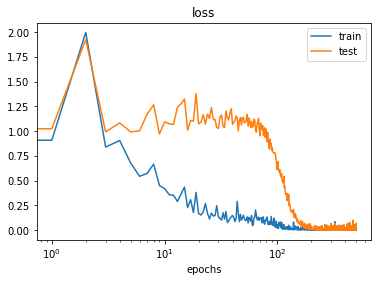

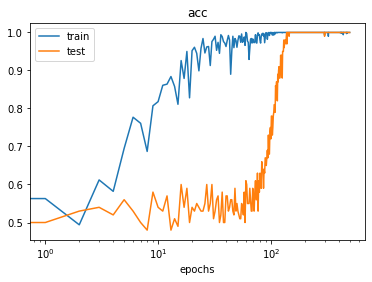

In [47]:
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.title('loss')
plt.xlabel('epochs')
plt.xscale('log')
plt.legend()
plt.show()


plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.title('acc')
plt.xlabel('epochs')
plt.xscale('log')
plt.legend()
plt.show()

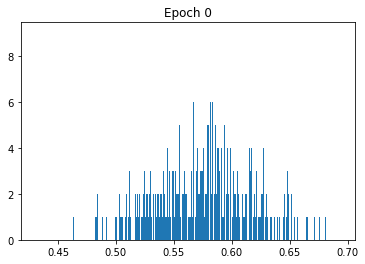

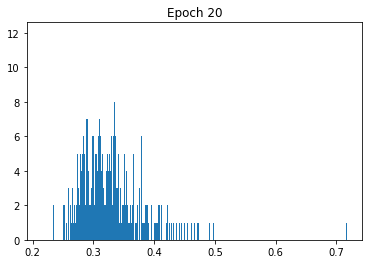

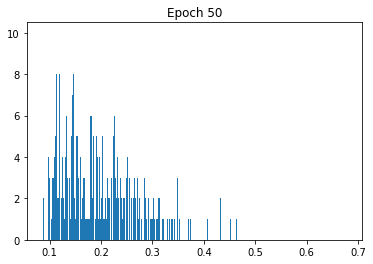

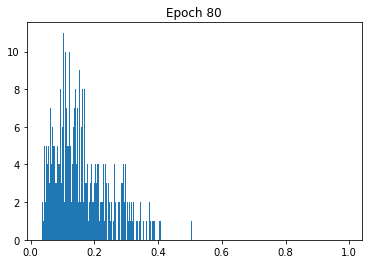

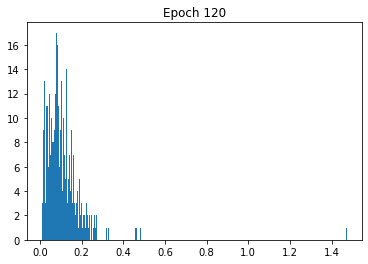

In [48]:
for k in [0, 20, 50, 80, 120]:
  plt.hist(norms['feats'][k], bins=len(norms['feats'][k]))
  plt.title(f'Epoch {k}')
  # plt.savefig(f'hist_{k}.png')
  plt.show()

700 254


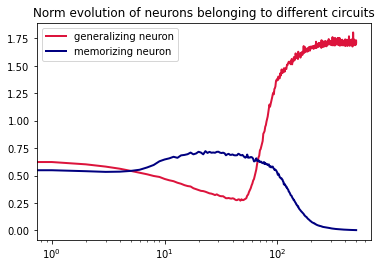

In [49]:
best = norms['feats'][120].argmax()
prev_best = norms['feats'][20].argmax()
print(best, prev_best)

traj, prev_traj = [], []
for k in range(T):
  traj.append(norms['feats'][k][best])
  prev_traj.append(norms['feats'][k][prev_best])

plt.plot(traj, label='generalizing neuron', lw=2, color='crimson')
plt.plot(prev_traj, label='memorizing neuron', lw=2, color='navy')
plt.title('Norm evolution of neurons belonging to different circuits')
plt.xscale('log')
plt.legend()
plt.show()

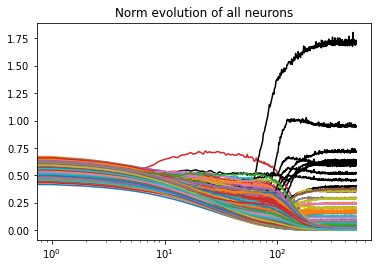

In [50]:
# best = norms['feats'][120].argmax()
# prev_best = norms['feats'][20].argmax()

trajs = []
for neuron in range(1000):
  trajs.append([])
  for k in range(T):
    trajs[-1].append(norms['feats'][k][neuron])

sorted_idx = np.array(norms['feats'][-1]).argsort()
for neuron in range(1000):
  if (neuron in sorted_idx[-10:]):
    plt.plot(trajs[neuron], color='black')
  else:
    plt.plot(trajs[neuron])
  plt.title('Norm evolution of all neurons')
  plt.xscale('log')
plt.show()

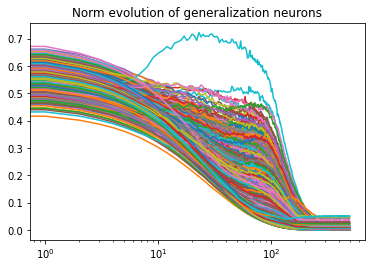

In [51]:
import numpy as np
top_k = 40
circuit_gen = np.array(norms['feats'][-1]).argsort()[:-top_k]

trajs = []
for neuron in list(circuit_gen):
  trajs.append([])
  for k in range(T):
    trajs[-1].append(norms['feats'][k][neuron])

for neuron in range(len(list(circuit_gen))):
  plt.plot(trajs[neuron])
  plt.title('Norm evolution of generalization neurons')
  plt.xscale('log')
plt.show()

In [62]:
# def masked_forward(input, model, active):
#   h = nn.ReLU(list(model.parameters())[0][active].to(device) @ input.to(device).T + list(model.parameters())[1][active])
#   print(h.shape)

# masked_forward(x_batch, model, circuit_gen)

RuntimeError: ignored

In [55]:
x_batch.shape

torch.Size([8, 40])